In [135]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import seaborn as sns
from scipy import stats

import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import warnings
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score, precision_score, accuracy_score
import itertools
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

# implementations

In [137]:
def data_loader(dataset, genome_path, pheno_path, data_path):
    if dataset == 'human1000':
        gen = pd.read_csv(genome_path, sep ='\t')
        gen = gen.drop(['FID', 'PAT', 'MAT', 'SEX', 'PHENOTYPE'], axis = 1).set_index('IID')
        gen.columns = ['SNP'+str(i+1) for i in range(gen.shape[1])]

        phey = pd.read_csv(pheno_path, header=None, index_col=0)
        phey[1] = phey[1].replace([1,-9],0)
        phey[1] = phey[1].replace([2],1)

        gen['y']=phey[1]
        
        if not os.path.isdir(data_path):
            os.makedirs(data_path)
            
        gen.to_csv(data_path +'/dataset.csv')
        
    elif dataset == 'openSNP':
        gen = pd.read_csv('../data/eyecolor/gwas.csv')
    
    else:
        print('not default dataset')
    
    return gen

In [138]:
def obtain_label(data, thresholds):
    """
    Given the p-values for each iteration and the thresholds
    Return the class label for each iteration
    """
    data_new = pd.DataFrame(columns=data.columns)
    data_new['SNP'] = data['SNP']
   # data_new['group'] = data['group']
    for col in list(data_new.columns)[1:]:
        data_new[col] = pd.cut(data[col], bins=[0] + list(thresholds.values())[:-1] + [float('inf')],
                    labels=list(thresholds.keys()))
    return data_new
    

In [139]:
def get_pvalues(data):
    #df = pd.DataFrame({'x': x, 'y': y})
    p_value=[]
   # betas = []
    for i in range(data.shape[1]-2):
        df = pd.DataFrame({'x': data.iloc[:,i], 'y': data['y']})
        df['intecept']=1
        try:
            logit_model=sm.Logit(df['y'],df[['x','intecept']],missing = 'drop')
            result=logit_model.fit(disp=0)
            p_value.append(result.pvalues[0])
         #   betas.append(result.params[0])
        except:
            p_value.append(2)
         #   betas.append(0)
    return np.array(p_value)

In [140]:
def partition(dataset, data, scenario, seed):
    case_ = data['y'] == 1
    control_ = data['y'] == 0
    
    if dataset == 'human1000':
        if scenario == '3' or secnario == '5' :
            data_A_case = data[case_].sample(300, random_state = seed)
            data_A_control = data[control_].sample(900, random_state = seed)

            data_B_case =  data[case_].loc[~ data[case_].index.isin(data_A_case.index)]
            data_B_control =  data[control_].loc[~ data[control_].index.isin(data_A_control.index)]
        elif scenario == '4':
            data_A_case = data[case_].sample(450, random_state = seed)
            data_A_control = data[control_].sample(750, random_state = seed)

            data_B_case =  data[case_].loc[~ data[case_].index.isin(data_A_case.index)]
            data_B_control =  data[control_].loc[~ data[control_].index.isin(data_A_control.index)]
            
        else :
            ## when both are balanced or when party A (case:control= 600:600) and party B (case:control=300:900)
            data_A_case = data[case_].sample(600, random_state = seed)
            data_A_control = data[control_].sample(600, random_state = seed)

            data_B_case =  data[case_].loc[~ data[case_].index.isin(data_A_case.index)]
            data_B_control =  data[control_].loc[~ data[control_].index.isin(data_A_control.index)]

        data_A = pd.concat([data_A_case, data_A_control]).sample(len(data_A_case) + len(data_A_control))
        data_B = pd.concat([data_B_case, data_B_control]).sample(len(data_B_case) + len(data_B_control))
    elif dataset == 'opensnp':
        data_A_case = data[case_].sample(200, random_state = seed)
        data_A_control = data[control_].sample(200, random_state = seed)
        
        data_B_case =  data[case_].loc[~ data[case_].index.isin(data_A_case.index)]
        data_B_control =  data[control_].loc[~ data[control_].index.isin(data_A_control.index)]
        
        data_A = pd.concat([data_A_case, data_A_control]).sample(len(data_A_case) + len(data_A_control))
        data_B = pd.concat([data_B_case, data_B_control]).sample(len(data_B_case) + len(data_B_control))
    
    else:
        print('not default dataset')
    
    return data_A, data_B

In [141]:
def save_results(res, data_path, file_name):
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
    
    if isinstance(res, pd.DataFrame):
        res.to_csv(data_path + file_name + '.csv', index = False)
    else:
         with open(data_path + file_name + '.pkl', 'wb') as f:
                pickle.dump(res, f)
        

In [142]:
class process_1():
    def __init__(self, data_A, data_B):
        self.data_A = data_A
        self.data_B = data_B
    
    def fit(self):
        p_A = pd.DataFrame({'SNP': data_A.columns[:-2]})
        p_B = pd.DataFrame({'SNP': data_B.columns[:-2]})
        
        p_A['p_value'] = get_pvalues(data_A)
        p_B['p_value'] = get_pvalues(data_B)
        
        return p_A, p_B
    
    def predict(self, p_A, p_B, thresholds):
        
        p_A_label = obtain_label(p_A, thresholds)
        p_B_label = obtain_label(p_B, thresholds)
        
        insig_A = set(p_A_label[p_A_label['p_value'] ==0]['SNP'])
        insig_B = set(p_B_label[p_B_label['p_value'] ==0]['SNP'])
        
        insig_list = list(insig_A.intersection(insig_B))
        sig_list = list(p_A_label[~p_A_label.set_index('SNP').index.isin(insig_list)]['SNP'])
        
        p_A_label['predict_label']= [1 for _ in range(len(p_A_label))]
        p_A_label['predict_label'].mask(p_A_label.set_index('SNP').index.isin(insig_list), 0, inplace = True)
        
        p_B_label['predict_label']= [1 for _ in range(len(p_B_label))]
        p_B_label['predict_label'].mask(p_B_label.set_index('SNP').index.isin(insig_list), 0, inplace = True)
        
        return p_A_label, p_B_label, insig_list, sig_list
    
    def evaluate(self, gt_pval, p_A_label):
        true_label = gt_pval['Label']
        predict_label = p_A_label['predict_label']
        
        tn, fp, fn, tp = confusion_matrix(true_label, predict_label).ravel()
    
        return fn, tn

In [143]:
class process_2():
    
    def __init__(self, data_A, data_B, insig_list, nss, seeds):

        self.data_A = data_A
        self.data_B = data_B
        self.insig_list = insig_list
        self.nss = nss
        self.seeds = seeds


    def iterative_uni(self, data1, data2):
        """
        uniformly sampling records and get inference
        nss: iteratiton rounds
        seed: random state
        """
        p_value = np.zeros((data1.shape[1]-2,len(self.nss)))

        selected_uni = []

        for idn, n in enumerate(self.nss):
            df_uni1 = data1.sample(n, random_state = self.seeds[idn])
            df_uni2 = data2.sample(n, random_state = self.seeds[idn])
            
            df_uni = pd.concat([df_uni1, df_uni2], axis = 0)
            df_uni = df_uni.sample(len(df_uni))
    
            p_value[:,idn] = get_pvalues(df_uni)

            selected_uni.append(list(df_uni1.index))


        return p_value, selected_uni
    
    def ensembleVote(self, data):
        """
        Given the class label for each iteration
        Return the class label via majority voting 
        """
        data_new = pd.DataFrame(columns=data.columns)
        data_new['SNP'] = data['SNP']
       # data_new['p_value'] = data['p_value']
       # data_new['group'] = data['group']

        for idn in range(len(self.nss)):
            if idn == 0:
                data_new[str(idn+1)] = data[str(idn+1)]
            else:
                iters = [str(i+1) for i in range(idn+1)]
                u = data[iters].mode(axis=1).iloc[:, 0]

                #TODO: figure out how to break the tie

                #if len(u.columns) > 1:
                 #   u = u.iloc[:, 0].where(u.iloc[:, 1:].isna().all(axis=1))
                data_new[str(idn+1)] = u

       # data_new.fillna()

        return data_new

    def fit(self):
        
        """
        uniformly sampling records and get inference
        nss: list of subset size
        seed: random state
        """
        
        # filter out the insig snps from step 1
        data_A_sub = self.data_A.loc[:,~self.data_A.columns.isin(self.insig_list)]
        data_B_sub = self.data_B.loc[:,~self.data_B.columns.isin(self.insig_list)]
                
       # data_sub = pd.concat([data_A_sub, data_B_sub], axis = 0)
       # data_sub = data_sub.sample(len(data_sub))
        
        # obtain the p values of each iteration for the remaning SNPs 
        return self.iterative_uni(data_A_sub, data_B_sub)

    def predict(self, p_value_uni, column_list, thresholds):
        # get label for each iteration 
        
        p_values = pd.DataFrame({'SNP': column_list})
        
        for idn, n in enumerate(nss): 
            p_uni_sample= dict(zip(column_list, p_value_uni[:,idn]))
            
            p_values[str(idn+1)] = p_values['SNP'].map(p_uni_sample)

    
        iter_label = obtain_label(p_values, thresholds)
        
        # get the label at each iteration via voting
        vote_label = self.ensembleVote(iter_label)
        return p_values, iter_label, vote_label
    
    
    def evaluate_process2(self, gt_pval, vote_label):
        true_label = gt_pval[~gt_pval.set_index('SNP').index.isin(self.insig_list)]['Label']
        tp_ = []
        fn_ = []
        
        for idn in range(len(nss)):
            predict_label = vote_label[str(idn+1)]
            tn, fp, fn, tp = confusion_matrix(true_label, predict_label).ravel()
            tp_.append(tp)
            fn_.append(fn)
            
        return tp_, fn_
    
    def evaluate_overall(self, gt_pval, vote_label):
        true_label = gt_pval['Label']

        predict_label = pd.DataFrame({'SNP': self.data_A.columns[:-2]})
        
        for idn in range(len(nss)):            
            label_iter = np.zeros((len(self.data_A.columns[:-2])))
            idx_list = [list(self.data_A.columns[:-2]).index(snp) for snp in self.insig_list]
    
            mask = np.ones(len(label_iter), dtype=bool)
            mask[idx_list] = False

            label_iter[mask] = vote_label[str(idn+1)]

            predict_label[str(idn+1)] = label_iter
            
        return predict_label

# experiments

In [ ]:
data = data_loader('human1000', '../../../Downloads/1000/all_hg38.raw', 
                   '../../../Downloads/1000/scn1.csv', '../results/1000/')

In [30]:
iters = 5
batch_size = [100, 300, 500, 700, 900, 1100]
p_thre = [0.005, 0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [0, 100, 210, 970, 3506, 23525, 32451, 2466, 1242]

data = pd.read_csv('../results/1000/dataset.csv', index_col='IID')

gt_pval = pd.read_csv('../results/1000/centralized/gt_pval.csv') 


step1_time = []
step2_time = []
for i_iter in range(iters):
    data_A, data_B = partition('human1000', data, '1', seeds[i_iter])
    for p_idx, p0 in enumerate(p_thre):        
        thresholds = {1: p0, 0: 1}  
        step1_path = '../results/1000/sc1/test' + str(i_iter) + '/' + str(list(thresholds.values())[0]) + '/step1/'
        
        if p_idx == 0:
        # start step 1 only compute the p-values once for a and b
            t0 = time.time()
            step1 = process_1(data_A, data_B)
            p_A, p_B = step1.fit()
            p_A_label, p_B_label, insig_list, column_list = step1.predict(p_A, p_B, thresholds)
            t1 = time.time()
            step1_time.append(t1-t0)

            save_results(p_A,step1_path,'p_A')
            save_results(p_B,step1_path, 'p_B')
        else:
            p_A = pd.read_csv('../results/1000/sc1/test' + str(i_iter) + '/' + str(0.005) + '/step1/'+'p_A.csv')
            p_B = pd.read_csv('../results/1000/sc1/test' + str(i_iter) + '/' + str(0.005) + '/step1/'+'p_B.csv')
            
            p_A_label, p_B_label, insig_list, column_list = step1.predict(p_A, p_B, thresholds)
              
        print('finish step1')
        # save step 1 res
        
        save_results(p_A_label, step1_path, 'p_A_label')
        save_results(column_list, step1_path, 'sig_list')
        save_results(insig_list, step1_path, 'insig_list')
        
        # start step 2 
        step2_path = '../results/1000/sc1/test'+str(i_iter)+'/'+str(list(thresholds.values())[0])+'/step2/'

                        
        for bs in tqdm(batch_size):
            nss = [bs for _ in range(9)]

            t2 = time.time()

            step2 = process_2(data_A, data_B, insig_list, nss, seeds)
            p_value_uni, selected_idx = step2.fit()
            pval, iter_label, vote_label = step2.predict(p_value_uni, column_list,  thresholds)
            step2_time.append(time.time() - t2)
            all_pred = step2.evaluate_overall(gt_pval, vote_label)

            save_results(p_value_uni, step2_path +str(bs)+'/', 'p_value_uni')
            save_results(selected_idx, step2_path +str(bs)+'/', 'selected_idx')

            save_results(pval, step2_path +str(bs)+'/' , 'pval')
            save_results(iter_label, step2_path +str(bs)+'/', 'iter_label')
            save_results(vote_label, step2_path +str(bs)+'/', 'vote_label')
            save_results(all_pred, step2_path +str(bs)+'/', 'all_pred')
                            
save_results(step1_time, '../results/1000/sc1/', 'step1_time')
save_results(step2_time, '../results/1000/sc1/', 'step2_time')


finish step1


100%|█████████████████████████████████████████████| 6/6 [03:35<00:00, 35.93s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:28<00:00, 54.75s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:18<00:00, 63.16s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:44<00:00, 67.36s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:30<00:00, 75.09s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [08:27<00:00, 84.53s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [03:35<00:00, 35.86s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:34<00:00, 55.77s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:32<00:00, 65.39s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:09<00:00, 71.63s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:39<00:00, 76.56s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [08:25<00:00, 84.20s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [03:27<00:00, 34.61s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:18<00:00, 53.00s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:30<00:00, 65.04s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:50<00:00, 68.35s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:30<00:00, 75.08s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [08:13<00:00, 82.22s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [03:28<00:00, 34.77s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:28<00:00, 54.77s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:26<00:00, 64.39s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:58<00:00, 69.73s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:26<00:00, 74.37s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [08:23<00:00, 83.97s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [03:29<00:00, 34.88s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:07<00:00, 51.19s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:53<00:00, 58.95s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:50<00:00, 68.36s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:45<00:00, 77.62s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [08:07<00:00, 81.30s/it]


In [ ]:
iters = 5
batch_size = [100, 300, 500, 700, 900, 1100]
p_thre = [0.005, 0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [0, 100, 210, 970, 3506, 23525, 32451, 2466, 1242]


data = pd.read_csv('../results/1000/dataset.csv')

gt_pval = pd.read_csv('../results/1000/centralized/gt_pval.csv') 


step1_time = []
step2_time = []
for i_iter in range(iters):
    data_A, data_B = partition('human1000', data, '2', seeds[i_iter])
    for p_idx, p0 in enumerate(p_thre):        
        thresholds = {1: p0, 0: 1}  
        step1_path = '../results/1000/sc1/test' + str(i_iter) + '/' + str(list(thresholds.values())[0]) + '/step1/'
        
        if p_idx == 0:
        # start step 1 only compute the p-values once for a and b
            t0 = time.time()
            step1 = process_1(data_A, data_B)
            p_A, p_B = step1.fit()
            p_A_label, p_B_label, insig_list, column_list = step1.predict(p_A, p_B, thresholds)
            t1 = time.time()
            step1_time.append(t1-t0)

            save_results(p_A,step1_path,'p_A')
            save_results(p_B,step1_path, 'p_B')
        else:
            p_A = pd.read_csv('../results/1000/sc2/test' + str(i_iter) + '/' + str(0.005) + '/step1/'+'p_A.csv')
            p_B = pd.read_csv('../results/1000/sc2/test' + str(i_iter) + '/' + str(0.005) + '/step1/'+'p_B.csv')
            
            p_A_label, p_B_label, insig_list, column_list = step1.predict(p_A, p_B, thresholds)
              
        print('finish step1')
        # save step 1 res
        
        save_results(p_A_label, step1_path, 'p_A_label')
        save_results(column_list, step1_path, 'sig_list')
        save_results(insig_list, step1_path, 'insig_list')
        
        # start step 2 
        step2_path = '../results/1000/sc2/test'+str(i_iter)+'/'+str(list(thresholds.values())[0])+'/step2/'
        if p_idx == 0: # same here, for each batch size, only need to compute the p-values once 
            
            for bs in tqdm(batch_size):
                nss = [bs for _ in range(9)]

                t2 = time.time()

                step2 = process_2(data_A, data_B, insig_list, nss, seeds)
                p_value_uni, selected_idx = step2.fit()
                pval, iter_label, vote_label = step2.predict(p_value_uni, column_list,  thresholds)
                step2_time.append(time.time() - t2)
                all_pred = step2.evaluate_overall(gt_pval, vote_label)
                
                save_results(p_value_uni, step2_path +str(bs)+'/', 'p_value_uni')
                save_results(selected_idx, step2_path +str(bs)+'/', 'selected_idx')

                save_results(pval, step2_path +str(bs)+'/' , 'pval')
                save_results(iter_label, step2_path +str(bs)+'/', 'iter_label')
                save_results(vote_label, step2_path +str(bs)+'/', 'vote_label')
                save_results(all_pred, step2_path +str(bs)+'/', 'all_pred')

        else:
            for bs in tqdm(batch_size):
                nss = [bs for _ in range(9)]
                step2 = process_2(data_A, data_B, insig_list, nss, seeds)
                
                with open('../results/1000/sc2/test' + str(i_iter) + '/' + str(0.005) + '/step2/'+str(bs)+ '/p_value_uni.pkl', 'rb') as f:
                    p_value_uni = pickle.load(f)
                
                pval, iter_label, vote_label = step2.predict(p_value_uni, column_list, thresholds)
                all_pred = step2.evaluate_overall(gt_pval, vote_label)
                
                save_results(pval, step2_path +str(bs)+'/' , 'pval')
                save_results(iter_label, step2_path +str(bs)+'/', 'iter_label')
                save_results(vote_label, step2_path +str(bs)+'/', 'vote_label')
                save_results(all_pred, step2_path +str(bs)+'/', 'all_pred')
                            
save_results(step1_time, '../results/1000/sc2/', 'step1_time')
save_results(step2_time, '../results/1000/sc2/', 'step2_time')


In [22]:
iters = 5
batch_size = [100, 300, 500, 700, 900, 1100]
p_thre = [0.005, 0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [0, 100, 210, 970, 3506, 23525, 32451, 2466, 1242]


data = pd.read_csv('../results/1000/dataset.csv')

gt_pval = pd.read_csv('../results/1000/centralized/gt_pval.csv') 


step1_time = []
step2_time = []
for i_iter in range(iters):
    data_A, data_B = partition('human1000', data, '3', seeds[i_iter])
    print(len(data_A[data_A['y']==0]))
    print(len(data_A[data_A['y']==1]))

    for p_idx, p0 in enumerate(p_thre):        
        thresholds = {1: p0, 0: 1}  
        step1_path = '../results/1000/sc4/test' + str(i_iter) + '/' + str(list(thresholds.values())[0]) + '/step1/'
        
        if p_idx == 0:
        # start step 1 only compute the p-values once for a and b
            t0 = time.time()
            step1 = process_1(data_A, data_B)
            p_A, p_B = step1.fit()
            p_A_label, p_B_label, insig_list, column_list = step1.predict(p_A, p_B, thresholds)
            t1 = time.time()
            step1_time.append(t1-t0)

            save_results(p_A,step1_path,'p_A')
            save_results(p_B,step1_path, 'p_B')
        else:
            p_A = pd.read_csv('../results/1000/sc4/test' + str(i_iter) + '/' + str(0.005) + '/step1/'+'p_A.csv')
            p_B = pd.read_csv('../results/1000/sc4/test' + str(i_iter) + '/' + str(0.005) + '/step1/'+'p_B.csv')
            
            p_A_label, p_B_label, insig_list, column_list = step1.predict(p_A, p_B, thresholds)
              
        print('finish step1')
        # save step 1 res
        
        save_results(p_A_label, step1_path, 'p_A_label')
        save_results(column_list, step1_path, 'sig_list')
        save_results(insig_list, step1_path, 'insig_list')
        
        # start step 2 
        step2_path = '../results/1000/sc4/test'+str(i_iter)+'/'+str(list(thresholds.values())[0])+'/step2/'
            
        for bs in tqdm(batch_size):
            nss = [bs for _ in range(9)]

            t2 = time.time()

            step2 = process_2(data_A, data_B, insig_list, nss, seeds)
            p_value_uni, selected_idx = step2.fit()
            pval, iter_label, vote_label = step2.predict(p_value_uni, column_list,  thresholds)
            step2_time.append(time.time() - t2)
            all_pred = step2.evaluate_overall(gt_pval, vote_label)

            save_results(p_value_uni, step2_path +str(bs)+'/', 'p_value_uni')
            save_results(selected_idx, step2_path +str(bs)+'/', 'selected_idx')

            save_results(pval, step2_path +str(bs)+'/' , 'pval')
            save_results(iter_label, step2_path +str(bs)+'/', 'iter_label')
            save_results(vote_label, step2_path +str(bs)+'/', 'vote_label')
            save_results(all_pred, step2_path +str(bs)+'/', 'all_pred')

                            
save_results(step1_time, '../results/1000/sc4/', 'step1_time')
save_results(step2_time, '../results/1000/sc4/', 'step2_time')


900
300
finish step1


100%|█████████████████████████████████████████████| 6/6 [07:34<00:00, 75.81s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:56<00:00, 59.37s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:01<00:00, 60.27s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:06<00:00, 71.13s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:22<00:00, 73.80s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:56<00:00, 79.34s/it]


900
300
finish step1


100%|█████████████████████████████████████████████| 6/6 [03:39<00:00, 36.60s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:21<00:00, 53.51s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:22<00:00, 63.80s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:28<00:00, 74.67s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:34<00:00, 75.67s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [08:10<00:00, 81.80s/it]


900
300
finish step1


100%|█████████████████████████████████████████████| 6/6 [03:37<00:00, 36.24s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [04:59<00:00, 49.94s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:47<00:00, 57.98s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:26<00:00, 64.40s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:09<00:00, 71.63s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:44<00:00, 77.40s/it]


900
300
finish step1


100%|█████████████████████████████████████████████| 6/6 [03:39<00:00, 36.56s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:23<00:00, 53.95s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:15<00:00, 62.63s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:55<00:00, 69.21s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:37<00:00, 76.25s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [08:26<00:00, 84.44s/it]


900
300
finish step1


100%|█████████████████████████████████████████████| 6/6 [03:37<00:00, 36.27s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:07<00:00, 51.31s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [05:54<00:00, 59.02s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [06:33<00:00, 65.57s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:15<00:00, 72.64s/it]


finish step1


100%|█████████████████████████████████████████████| 6/6 [07:50<00:00, 78.44s/it]


In [657]:
iters = 5
batch_size = [100, 200, 300]
p_thre = [0.15, 0.2, 0.25, 0.3]
seeds = [0, 100, 210, 970, 3506, 23525, 32451, 2466, 1242]


data = pd.read_csv('../data/eyecolor/gwas.csv')

step1_time = []
step2_time = []
for i_iter in tqdm(range(5)):
    data_A, data_B = partition('opensnp', data, '1', seeds[i_iter])
    for p_idx, p0 in enumerate(p_thre):        
        thresholds = {1: p0, 0: 1}  
        step1_path = '../results/oepnsnp/test' + str(i_iter) + '/' + str(list(thresholds.values())[0]) + '/step1/'
        
        if p_idx == 0:
        # start step 1 only compute the p-values once for a and b
            t0 = time.time()
            step1 = process_1(data_A, data_B)
            p_A, p_B = step1.fit()
            p_A_label, p_B_label, insig_list, column_list = step1.predict(p_A, p_B, thresholds)
            t1 = time.time()
            step1_time.append(t1-t0)

            save_results(p_A,step1_path,'p_A')
            save_results(p_B,step1_path, 'p_B')
        else:
            p_A = pd.read_csv('../results/oepnsnp/test' + str(i_iter) + '/' + str(0.15) + '/step1/'+'p_A.csv')
            p_B = pd.read_csv('../results/oepnsnp/test' + str(i_iter) + '/' + str(0.15) + '/step1/'+'p_B.csv')
            
            p_A_label, p_B_label, insig_list, column_list = step1.predict(p_A, p_B, thresholds)
              
        print('finish step1')
        # save step 1 res
        
        save_results(p_A_label, step1_path, 'p_A_label')
        save_results(column_list, step1_path, 'sig_list')
        save_results(insig_list, step1_path, 'insig_list')
        
        # start step 2 
        step2_path = '../results/oepnsnp/test'+str(i_iter)+'/'+str(list(thresholds.values())[0])+'/step2/'

                        
        for bs in batch_size:
            print(bs)
            nss = [bs for _ in range(9)]

            t2 = time.time()

            step2 = process_2(data_A, data_B, insig_list, nss, seeds)
            p_value_uni, selected_idx = step2.fit()
            pval, iter_label, vote_label = step2.predict(p_value_uni, column_list,  thresholds)
            step2_time.append(time.time() - t2)
            all_pred = step2.evaluate_overall(gt_pval, vote_label)

            save_results(p_value_uni, step2_path +str(bs)+'/', 'p_value_uni')
            save_results(selected_idx, step2_path +str(bs)+'/', 'selected_idx')

            save_results(pval, step2_path +str(bs)+'/' , 'pval')
            save_results(iter_label, step2_path +str(bs)+'/', 'iter_label')
            save_results(vote_label, step2_path +str(bs)+'/', 'vote_label')
            save_results(all_pred, step2_path +str(bs)+'/', 'all_pred')
                            
save_results(step1_time, '../results/oepnsnp/', 'step1_time')
save_results(step2_time, '../results/oepnsnp/', 'step2_time')


  0%|                                                     | 0/5 [00:00<?, ?it/s]

finish step1
100
200
300
finish step1
100
200
300
finish step1
100
200
300
finish step1
100
200
300


 20%|███████▊                               | 1/5 [1:13:37<4:54:30, 4417.72s/it]

finish step1
100
200
300
finish step1
100
200
300
finish step1
100
200
300
finish step1
100
200
300


 40%|███████████████▌                       | 2/5 [2:28:50<3:43:41, 4473.77s/it]

finish step1
100
200
300
finish step1
100
200
300
finish step1
100
200
300
finish step1
100
200
300


 60%|███████████████████████▍               | 3/5 [3:49:29<2:34:41, 4640.54s/it]

finish step1
100
200


 60%|███████████████████████▍               | 3/5 [4:03:01<2:42:00, 4860.36s/it]


KeyboardInterrupt: 

# Meta Analysis preperation for GWAR

In [88]:
data = pd.read_csv('../results/1000/dataset.csv', index_col='IID')

In [70]:
dict(data['SNP35'].value_counts())

{2: 2327, 1: 73}

In [45]:
snp_list = list(data.columns[:-2])

In [62]:
A_counts = np.zeros((len(snp_list), 3))

In [94]:
def get_counts(data, snp_list):
    
    data_case = data[data['y']==1]
    data_control = data[data['y']==0]
    
    
    counts_case = np.zeros((len(snp_list), 3))
    counts_control = np.zeros((len(snp_list), 3))

    for idx, col in enumerate(snp_list):
        count_dict = dict(data_case[col].value_counts())
    
        for key in [0, 1, 2]:
            if key in count_dict:
                counts_case[idx, key] = int(count_dict[key])
            else:
                counts_case[idx, key] = 0

    for idx, col in enumerate(snp_list):
        count_dict = dict(data_control[col].value_counts())

        for key in [0, 1, 2]:
            if key in count_dict:
                counts_control[idx, key] = int(count_dict[key])
            else:
                counts_control[idx, key] = 0
    
    
    return np.hstack((counts_case, counts_control)).astype(int)

In [100]:
data

,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,SNP10,...,SNP9416,SNP9417,SNP9418,SNP9419,SNP9420,SNP9421,SNP9422,SNP9423,SNP9424,y
IID,,,,,,,,,,,,,,,,,,,,,
HG00096,2,2,0,2,1,2,2,2,2,2,...,2,1,2,2,2,2,2,2,2,0
HG00097,2,2,1,2,1,2,2,2,1,2,...,2,1,2,2,2,2,2,2,2,0
HG00099,2,2,0,1,1,2,2,2,2,1,...,2,1,2,2,2,2,2,2,2,0
HG00100,2,2,0,0,2,2,2,2,1,2,...,2,1,2,2,1,2,2,2,1,1
HG00101,2,2,0,2,2,2,2,2,1,2,...,2,1,2,2,2,2,2,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA20532,2,2,0,1,1,2,2,2,2,2,...,2,1,2,2,2,2,2,2,2,0
NA20533,1,2,0,0,1,2,2,2,2,1,...,2,0,2,2,2,2,2,2,2,0
NA20534,2,2,0,1,1,2,2,1,2,1,...,2,0,2,2,1,2,2,2,2,0


In [95]:
iters = 5
seeds = [0, 100, 210, 970, 3506, 23525, 32451, 2466, 1242]

data = pd.read_csv('../results/1000/dataset.csv', index_col='IID')
snp_list = list(data.columns[:-2])

for i_iter in range(iters):
    data_A, data_B = partition('human1000', data, '4', seeds[i_iter])
    print(len(data_A[data_A['y']==0]))
    print(len(data_B[data_B['y']==0]))

    # for data_A
    
    A_counts = get_counts(data_A, snp_list) 
    B_counts = get_counts(data_B, snp_list) 

    counts = pd.DataFrame(np.vstack((A_counts, B_counts)), 
                          columns = ['aa1', 'ab1', 'bb1', 'aa0', 'ab0', 'bb0'])
    counts['snp'] = snp_list + snp_list
    cols = ['snp', 'aa1', 'ab1', 'bb1', 'aa0', 'ab0', 'bb0']
    counts = counts.loc[:, cols]
    
    counts = counts.sample(len(counts))
    path = '../results/1000/gwar/sc2/'
    if not os.path.isdir(path):
        os.makedirs(path)
    
    counts.to_csv(path + 'test_' + str(i_iter) + '.txt', header = True, index=False, sep='\t')

750
450
750
450
750
450
750
450
750
450


In [96]:
iters = 5
seeds = [0, 100, 210, 970, 3506, 23525, 32451, 2466, 1242]

data = pd.read_csv('../results/1000/dataset.csv', index_col='IID')
snp_list = list(data.columns[:-2])

for i_iter in range(iters):
    data_A, data_B = partition('human1000', data, '3', seeds[i_iter])
    print(len(data_A[data_A['y']==0]))
    print(len(data_B[data_B['y']==0]))

    # for data_A
    
    A_counts = get_counts(data_A, snp_list) 
    B_counts = get_counts(data_B, snp_list) 

    counts = pd.DataFrame(np.vstack((A_counts, B_counts)), 
                          columns = ['aa1', 'ab1', 'bb1', 'aa0', 'ab0', 'bb0'])
    counts['snp'] = snp_list + snp_list
    cols = ['snp', 'aa1', 'ab1', 'bb1', 'aa0', 'ab0', 'bb0']
    counts = counts.loc[:, cols]
    
    counts = counts.sample(len(counts))
    path = '../results/1000/gwar/sc3/'
    if not os.path.isdir(path):
        os.makedirs(path)
    
    counts.to_csv(path + 'test_' + str(i_iter) + '.txt', header = True, index=False, sep='\t')

900
300
900
300
900
300
900
300
900
300


In [146]:
iters = 5
seeds = [0, 100, 210, 970, 3506, 23525, 32451, 2466, 1242]

data = pd.read_csv('../results/1000/dataset.csv', index_col='IID')
snp_list = list(data.columns[:-2])

for i_iter in range(iters):
    data_A, data_B = partition('human1000', data, '5', seeds[i_iter])
    
    # for data_A
    
    A_counts = get_counts(data_A, snp_list) 
    B_counts = get_counts(data_B, snp_list) 

    counts = pd.DataFrame(np.vstack((A_counts, B_counts)), 
                          columns = ['aa1', 'ab1', 'bb1', 'aa0', 'ab0', 'bb0'])
    counts['snp'] = snp_list + snp_list
    cols = ['snp', 'aa1', 'ab1', 'bb1', 'aa0', 'ab0', 'bb0']
    counts = counts.loc[:, cols]
    
    counts = counts.sample(len(counts))
    path = '../results/1000/gwar/sc3/'
    if not os.path.isdir(path):
        os.makedirs(path)
    
    counts.to_csv(path + 'test_' + str(i_iter) + '.txt', header = True, index=False, sep='\t')

# Evaluations

In [10]:
from sklearn.metrics import recall_score, precision_score, accuracy_score
import itertools

In [23]:
def get_gt_pval(data):
    p_value = get_pvalues(data)
    group_1 = data.columns[np.where(p_value<=0.005)[0]] #  significant
    group_2 = data.columns[np.where((p_value>0.005))] #  insignificant
    
    gp1 = dict(zip(group_1, [1 for _ in range(len(group_1))]))
    gp2 = dict(zip(group_2, [0 for _ in range(len(group_2))]))
    
    groups = {**gp1, **gp2}
    gt_pval = pd.DataFrame({'SNP': data.columns[:-2], 'p_value': p_value })

    gt_pval['Label'] = gt_pval['SNP'].map(groups)
    
    return gt_pval

In [42]:
def compute_metrics(dataset, result_path, method, thresholds,batch_size,p_thre, file_path):
    
    if dataset == 'human1000':
        if method == 'gwar':
            prcs = np.zeros((5,6))
            recall = np.zeros((5,6))
            for idx, sc in enumerate(['sc1', 'sc2', 'sc3', 'sc4', 'sc5']):
                gt_pval = pd.read_csv('../results/1000/' + sc + '/gt_pval.csv')
                for i_iter in range(5):
                    res = pd.read_csv(result_path + sc + '/test_' + str(i_iter) + 'results.txt', sep = '\t', header=None)
                    res.columns = ['SNP', 'p_value']
                    res = res.set_index('SNP')
                    res['indexNumber'] = [int(i.split('P')[-1]) for i in res.index]
                    res.sort_values('indexNumber',inplace=True, ascending=True)# Deletion of the added column
                    res.drop('indexNumber', 1, inplace = True)

                    res['pred'] = pd.cut(res['p_value'], bins=[-0.00001] + list(thresholds.values())[:-1] + [float('inf')],
                                labels=list(thresholds.keys()))
                    prcs[idx,i_iter] = precision_score(gt_pval['Label'],res['pred'], pos_label = 0)
                    recall[idx,i_iter] = recall_score(gt_pval['Label'],res['pred'], pos_label = 1)
            prcs[:,-1] = np.mean(prcs[:,:-1], axis=1)
            recall[:,-1] = np.mean(recall[:,:-1], axis=1)

            np.savetxt(file_path + 'overall_precision.txt', prcs)
            np.savetxt(file_path + 'overall_recall.txt', recall)
        else:
            prcs_1 = np.zeros((int(len(batch_size)*len(p_thre)),9))
            recall_1 = np.zeros((int(len(batch_size)*len(p_thre)),9))

            prcs_2 = np.zeros((int(len(batch_size)*len(p_thre)),9))
            recall_2 = np.zeros((int(len(batch_size)*len(p_thre)),9))

            tn = np.zeros((5, len(p_thre)))
            fn = np.zeros((5, len(p_thre)))

            for s_idx, sc in enumerate(['sc1', 'sc2', 'sc3', 'sc4', 'sc5']):
                gt_pval = pd.read_csv('../results/1000/' + sc + '/gt_pval.csv')

                prcs_overall = np.zeros((5,9))
                recall_overall = np.zeros((5,9))

                prcs_step2 = np.zeros((5,9))
                recall_step2 = np.zeros((5,9))
                for idx, (batch, p) in enumerate(list(itertools.product(batch_size, p_thre))):
                    for i_iter in range(5):
                        all_label = pd.read_csv(result_path+sc+'/' + 'test'+str(i_iter)+'/' + str(p) + '/step2/'+
                                                 str(batch) +'/all_pred.csv')
                        vote_label = pd.read_csv(result_path+sc+'/' + 'test'+str(i_iter)+'/' + str(p) + '/step2/'+
                                                 str(batch) +'/vote_label.csv')

                        prcs_overall[i_iter, :] = [precision_score(gt_pval['Label'], all_label.fillna(1)[str(i+1)], pos_label=0) for i in range(9)]
                        recall_overall[i_iter, :] = [recall_score(gt_pval['Label'], all_label.fillna(1)[str(i+1)], pos_label=1) for i in range(9)]


                        gt_pval[gt_pval.index.isin(vote_label.index)]
                        prcs_step2[i_iter, :] = [precision_score(gt_pval[gt_pval.set_index('SNP').index.isin(vote_label.set_index('SNP').index)]['Label'],
                                                                 vote_label.fillna(1)[str(i+1)], pos_label=0) for i in range(9)]
                        recall_step2[i_iter, :] = [recall_score(gt_pval[gt_pval.set_index('SNP').index.isin(vote_label.set_index('SNP').index)]['Label'],
                                                                vote_label.fillna(1)[str(i+1)], pos_label=1) for i in range(9)]


                    prcs_1[idx,:] = np.mean(prcs_overall,axis = 0)
                    recall_1[idx,:] = np.mean(recall_overall,axis = 0)

                    prcs_2[idx,:] = np.mean(prcs_step2,axis = 0)
                    recall_2[idx,:] = np.mean(recall_step2,axis = 0)


                tn_ = np.zeros((5, len(p_thre)))
                fn_ = np.zeros((5, len(p_thre)))

                for idx, p in enumerate(p_thre):
                    for i_iter in range(5):
                        step1_pre = pd.read_csv(result_path+sc+'/' + 'test'+str(i_iter)+'/' + str(p) + '/step1/'+ 
                                                '/p_A_label.csv')

                        truene, _, falsene, _ = confusion_matrix( gt_pval['Label'], step1_pre['predict_label']).ravel()
                        tn_[i_iter,idx] = truene
                        fn_[i_iter,idx] = falsene

                tn[s_idx,:] = np.mean(tn_, axis = 0)
                fn[s_idx,:] = np.mean(fn_, axis = 0)

                np.savetxt(file_path+ sc +'/overall_precision.txt',prcs_1)
                np.savetxt(file_path+ sc +'/overall_recall.txt',recall_1)

                np.savetxt(file_path+ sc +'/step2_precision.txt',prcs_2)
                np.savetxt(file_path+ sc +'/step2_recall.txt',recall_2)

            np.savetxt(file_path +'/step1_tn.txt',tn)
            np.savetxt(file_path +'/step1_fn.txt',fn)
    else:
        if method == 'gwar':
            prcs = np.zeros((1,6))
            recall = np.zeros((1,6))
            for i_iter in range(5):
                res = pd.read_csv(result_path  + '/test_' + str(i_iter) + 'results.txt', sep = '\t', header=None)
                res.columns = ['SNP', 'p_value']
                res = res.merge(gt_pval, how = 'right', on='SNP').drop(['p_value_y', 'Label'], 1).fillna(2)
                res.columns = ['SNP', 'p_value']
                
                res['pred'] = pd.cut(res['p_value'], bins=[-0.000001] + list(thresholds.values())[:-1] + [float('inf')],
                            labels=list(thresholds.keys()))
                prcs[0,i_iter] = precision_score(gt_pval['Label'],res['pred'], pos_label = 0)
                recall[0,i_iter] = recall_score(gt_pval['Label'],res['pred'], pos_label = 1)
            prcs[0,-1] = np.mean(prcs[:,:-1], axis=1)
            recall[0,-1] = np.mean(recall[:,:-1], axis=1)

            np.savetxt(file_path + 'overall_precision.txt', prcs)
            np.savetxt(file_path + 'overall_recall.txt', recall)
        else:
            prcs_1 = np.zeros((int(len(batch_size)*len(p_thre)),9))
            recall_1 = np.zeros((int(len(batch_size)*len(p_thre)),9))

            prcs_2 = np.zeros((int(len(batch_size)*len(p_thre)),9))
            recall_2 = np.zeros((int(len(batch_size)*len(p_thre)),9))

            tn = np.zeros((1, len(p_thre)))
            fn = np.zeros((1, len(p_thre)))

            
            prcs_overall = np.zeros((5,9))
            recall_overall = np.zeros((5,9))

            prcs_step2 = np.zeros((5,9))
            recall_step2 = np.zeros((5,9))
            for idx, (batch, p) in enumerate(list(itertools.product(batch_size, p_thre))):
                for i_iter in range(5):
                    all_label = pd.read_csv(result_path+'/' + 'test'+str(i_iter)+'/' + str(p) + '/step2/'+
                                             str(batch) +'/all_pred.csv')
                    vote_label = pd.read_csv(result_path+'/' + 'test'+str(i_iter)+'/' + str(p) + '/step2/'+
                                             str(batch) +'/vote_label.csv')

                    prcs_overall[i_iter, :] = [precision_score(gt_pval['Label'], all_label.fillna(1)[str(i+1)], pos_label=0) for i in range(9)]
                    recall_overall[i_iter, :] = [recall_score(gt_pval['Label'], all_label.fillna(1)[str(i+1)], pos_label=1) for i in range(9)]


                    gt_pval[gt_pval.index.isin(vote_label.index)]
                    prcs_step2[i_iter, :] = [precision_score(gt_pval[gt_pval.set_index('SNP').index.isin(vote_label.set_index('SNP').index)]['Label'],
                                                             vote_label.fillna(1)[str(i+1)], pos_label=0) for i in range(9)]
                    recall_step2[i_iter, :] = [recall_score(gt_pval[gt_pval.set_index('SNP').index.isin(vote_label.set_index('SNP').index)]['Label'],
                                                            vote_label.fillna(1)[str(i+1)], pos_label=1) for i in range(9)]


                prcs_1[idx,:] = np.mean(prcs_overall,axis = 0)
                recall_1[idx,:] = np.mean(recall_overall,axis = 0)

                prcs_2[idx,:] = np.mean(prcs_step2,axis = 0)
                recall_2[idx,:] = np.mean(recall_step2,axis = 0)


            tn_ = np.zeros((5, len(p_thre)))
            fn_ = np.zeros((5, len(p_thre)))

            for idx, p in enumerate(p_thre):
                for i_iter in range(5):
                    step1_pre = pd.read_csv(result_path+'/' + 'test'+str(i_iter)+'/' + str(p) + '/step1/'+ 
                                            '/p_A_label.csv')

                    truene, _, falsene, _ = confusion_matrix( gt_pval['Label'], step1_pre['predict_label']).ravel()
                    tn_[i_iter,idx] = truene
                    fn_[i_iter,idx] = falsene

            tn[0,:] = np.mean(tn_, axis = 0)
            fn[0,:] = np.mean(fn_, axis = 0)

            np.savetxt(file_path +'/overall_precision.txt',prcs_1)
            np.savetxt(file_path +'/overall_recall.txt',recall_1)

            np.savetxt(file_path +'/step2_precision.txt',prcs_2)
            np.savetxt(file_path +'/step2_recall.txt',recall_2)

            np.savetxt(file_path +'/step1_tn.txt',tn)
            np.savetxt(file_path +'/step1_fn.txt',fn)


In [47]:
compute_metrics('human1000', '../results/1000/', 'ours', thresholds,batch_size, p_thre, '../results/1000/'  )

# Graphs

In [79]:
font = {'family' : 'Times New Roman',
        'size'   : 24}
plt.rc('font', **font)
markers = ['o', 'v', '>', 'p', '1', '*', 's', 'p', 'h', '+', 'o', '+']
colrs = [ '#2a9d8f', '#8ab17d', '#f4a261', '#e76f51' , '#264653', '#7f5539', '#8f2d56', '#363073']

In [80]:
iters = 5
batch_size = [100, 300, 500, 700, 900, 1100]
p_thre = [0.005, 0.1, 0.15, 0.2, 0.25, 0.3]
seeds = [0, 100, 210, 970, 3506, 23525, 32451, 2466, 1242]


In [81]:
labels = []
for idx, (batch, p) in enumerate(list(itertools.product(batch_size, p_thre))):
    labels.append(r'K = ' + str(batch) + ' & ' + r'$\mu$ = ' + str(p))

In [82]:
labels

['K = 100 & $\\mu$ = 0.005',
 'K = 100 & $\\mu$ = 0.1',
 'K = 100 & $\\mu$ = 0.15',
 'K = 100 & $\\mu$ = 0.2',
 'K = 100 & $\\mu$ = 0.25',
 'K = 100 & $\\mu$ = 0.3',
 'K = 300 & $\\mu$ = 0.005',
 'K = 300 & $\\mu$ = 0.1',
 'K = 300 & $\\mu$ = 0.15',
 'K = 300 & $\\mu$ = 0.2',
 'K = 300 & $\\mu$ = 0.25',
 'K = 300 & $\\mu$ = 0.3',
 'K = 500 & $\\mu$ = 0.005',
 'K = 500 & $\\mu$ = 0.1',
 'K = 500 & $\\mu$ = 0.15',
 'K = 500 & $\\mu$ = 0.2',
 'K = 500 & $\\mu$ = 0.25',
 'K = 500 & $\\mu$ = 0.3',
 'K = 700 & $\\mu$ = 0.005',
 'K = 700 & $\\mu$ = 0.1',
 'K = 700 & $\\mu$ = 0.15',
 'K = 700 & $\\mu$ = 0.2',
 'K = 700 & $\\mu$ = 0.25',
 'K = 700 & $\\mu$ = 0.3',
 'K = 900 & $\\mu$ = 0.005',
 'K = 900 & $\\mu$ = 0.1',
 'K = 900 & $\\mu$ = 0.15',
 'K = 900 & $\\mu$ = 0.2',
 'K = 900 & $\\mu$ = 0.25',
 'K = 900 & $\\mu$ = 0.3',
 'K = 1100 & $\\mu$ = 0.005',
 'K = 1100 & $\\mu$ = 0.1',
 'K = 1100 & $\\mu$ = 0.15',
 'K = 1100 & $\\mu$ = 0.2',
 'K = 1100 & $\\mu$ = 0.25',
 'K = 1100 & $\\mu$ = 0.3'

## Overall

In [50]:
idx_list = [10, 11, 16, 17]
#idx_list = [4, 5, 10, 11, 16, 17, 22, 23, 28,29, 34, 35 ]
selected_label = ['TDS (' + labels[i] + ')' for i in idx_list]

all_recall = np.zeros((5,4))
all_pre = np.zeros((5,4))

recall_list = []
pre_list = []
for idx, sc in enumerate(['sc1', 'sc2', 'sc3', 'sc4', 'sc5']):
    recall = np.loadtxt('../results/1000/' + sc +'/overall_recall.txt')
    precision = np.loadtxt('../results/1000/' + sc +'/overall_precision.txt')
    
    all_recall[idx,:] = recall[idx_list,np.argmax(recall[idx_list], axis=1) ]
    all_pre[idx, :] = precision[idx_list, np.argmax(precision[idx_list], axis=1)]
    
    recall_list.append(np.argmax(recall[idx_list],axis=1))
    pre_list.append(np.argmax(precision[idx_list],axis=1))

    
gwar_recall = np.loadtxt('../results/1000/gwar/overall_recall.txt')
gwar_precesion =  np.loadtxt('../results/1000/gwar/overall_precision.txt')

all_recall = all_recall.transpose()
all_pre = all_pre.transpose()

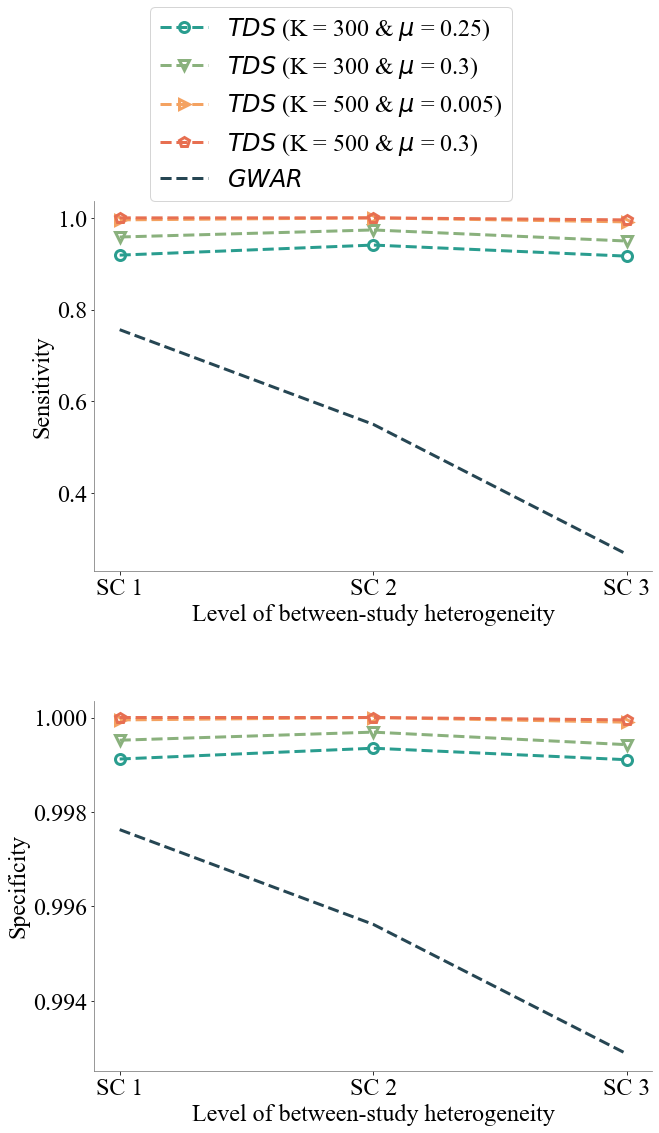

In [132]:
f1, axs1 = plt.subplots(2, 1, figsize=(10, 16))
axs1 = axs1.ravel()

metrics = ['Sensitivity', 'Specificity']

for i, res in enumerate([recall, precision]):
    if i==0:
        for index, label in enumerate(selected_label):
            axs1[i].plot([('SC ' + str(i_iter+1)) for i_iter in range(3)] , all_recall[index,[0,1,2]], lw=3,
                         marker = markers[index], markersize = 10, markeredgewidth=3,color=colrs[index],
                         linestyle='--',markerfacecolor="None",
                     label=label)
        axs1[i].plot([('SC ' + str(i_iter+1)) for i_iter in range(3)],gwar_recall[[0, 1,2],-1], color='#264653', 
                     linestyle='--', lw=3, label = r'$\it{GWAR}$')

        axs1[i].set_xlabel('Level of between-study heterogeneity')
        axs1[i].set_ylabel('%s' %(metrics[i]))
       #axs1[i].set_title('%s' %(metrics[i]))
    else:
        for index, label in enumerate(selected_label):
            axs1[i].plot([('SC ' + str(i_iter+1)) for i_iter in range(3)] , all_pre[index,[0,1,2]],
                         marker = markers[index], markersize =10, markeredgewidth=3,color=colrs[index],
                         linestyle='--', lw = 3,markerfacecolor="None",
                     label=label)
        axs1[i].plot([('SC ' + str(i_iter+1)) for i_iter in range(3)],gwar_precesion[[0, 1,2],-1],lw=3, 
                     color='#264653', linestyle='--', label = r'$\it{GWAR}$')

        axs1[i].set_xlabel('Level of between-study heterogeneity')
        axs1[i].set_ylabel('Specificity')
        #axs1[i].set_title('%s' %(metrics[i]))

    #axs1[i].title('Receiver operating characteristic for multi-class data')
   # axs1[i].legend(loc="best")
    
   # if i > 0 :
    #    axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i].spines[spine].set_edgecolor('gray')

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
    if i==0:
        axs1[i].legend(loc=(0.1, 1),ncol=1)
plt.subplots_adjust(wspace=0.05,hspace=0.35)
plt.savefig('../paper_codes/overall_123.jpg', dpi= 400, bbox_inches = "tight")
plt.show()

In [72]:
idx_list = [10, 11, 16, 17]
#idx_list = [4, 5, 10, 11, 16, 17, 22, 23, 28,29, 34, 35 ]
selected_label = ['TSIF (' + labels[i] + ')' for i in idx_list]     

In [74]:
all_recall = np.zeros((5,4))
all_pre = np.zeros((5,4))

recall_list = []
pre_list = []
for idx, sc in enumerate(['sc1', 'sc2', 'sc3', 'sc4', 'sc5']):
    recall = np.loadtxt('../results/1000/' + sc +'/overall_recall.txt')
    precision = np.loadtxt('../results/1000/' + sc +'/overall_precision.txt')
    
    all_recall[idx,:] = recall[idx_list,np.argmax(recall[idx_list], axis=1) ]
    all_pre[idx, :] = precision[idx_list, np.argmax(precision[idx_list], axis=1)]
    
    recall_list.append(np.argmax(recall[idx_list],axis=1))
    pre_list.append(np.argmax(precision[idx_list],axis=1))

    
gwar_recall = np.loadtxt('../results/1000/gwar/overall_recall.txt')
gwar_precesion =  np.loadtxt('../results/1000/gwar/overall_precision.txt')

all_recall = all_recall.transpose()
all_pre = all_pre.transpose()

ValueError: x and y must have same first dimension, but have shapes (3,) and (5,)

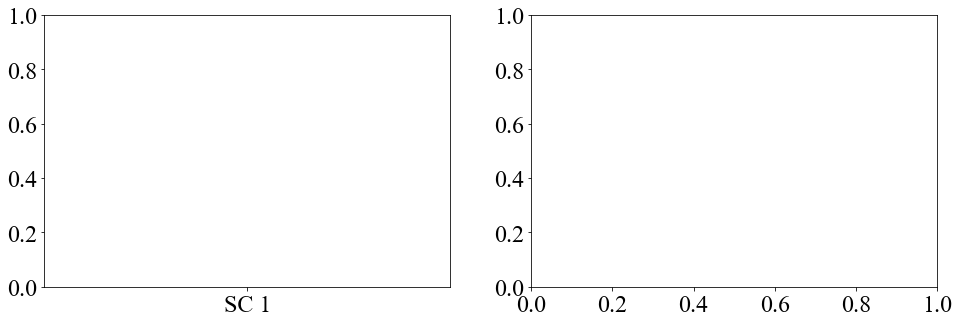

In [75]:
f1, axs1 = plt.subplots(1, 2, figsize=(16, 5))
axs1 = axs1.ravel()

metrics = ['Recall', 'Specificity']

for i, res in enumerate([recall, precision]):
    if i==0:
        for index, label in enumerate(selected_label):
            axs1[i].plot([('SC ' + str(i_iter+1)) for i_iter in range(3)] , all_recall[index,:], lw=3,
                         marker = markers[index], markersize = 10, markeredgewidth=3,color=colrs[index],
                         linestyle='--',markerfacecolor="None",
                     label=label)
        axs1[i].plot([('SC ' + str(i_iter+1)) for i_iter in range(3)],gwar_recall[:,-1], color='#264653', 
                     linestyle='--', lw=3, label = 'GWAR')

        axs1[i].set_xlabel('Level of study heterogenity')
        axs1[i].set_ylabel('Rate')
        axs1[i].set_title('%s' %(metrics[i]))
    else:
        for index, label in enumerate(selected_label):
            axs1[i].plot([('SC ' + str(i_iter+1)) for i_iter in range(3)] , all_pre[index,:],
                         marker = markers[index], markersize =10, markeredgewidth=3,color=colrs[index],
                         linestyle='--', lw = 3,markerfacecolor="None",
                     label=label)
        axs1[i].plot([('SC ' + str(i_iter+1)) for i_iter in range(3)],gwar_precesion[:,-1],lw=3, 
                     color='#264653', linestyle='--', label = 'GWAR')

        axs1[i].set_xlabel('Level of study heterogenity')
        axs1[i].set_ylabel('Rate')
        axs1[i].set_title('%s' %(metrics[i]))

    #axs1[i].title('Receiver operating characteristic for multi-class data')
   # axs1[i].legend(loc="best")
    
    if i > 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i].spines[spine].set_edgecolor('gray')

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
    if i==0:
        axs1[i].legend(loc=(0, 1.2),ncol=3)
plt.subplots_adjust(wspace=0.15,hspace=0.05)
plt.savefig('../paper_codes/overall.jpg', dpi= 400, bbox_inches = "tight")
plt.show()

## Step2

In [103]:
#idx_list = [10, 11, 16, 17]
idx_list = [10, 11, 12, 17]
selected_label = [r'$\it{TDS}$ (' + labels[i] + ')' for i in idx_list]

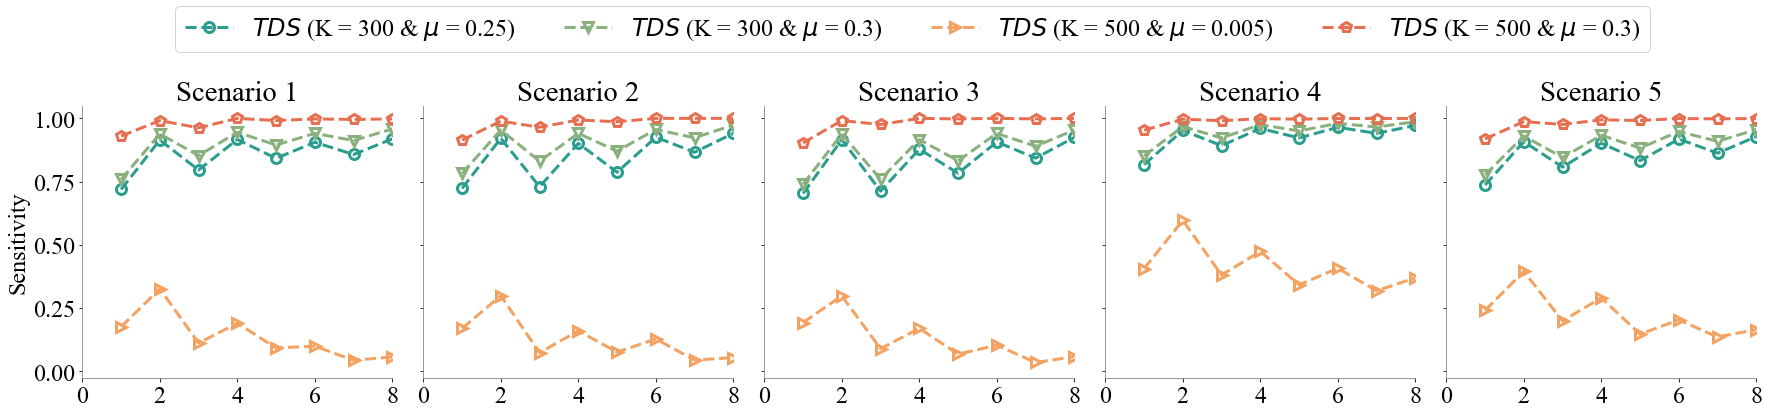

In [134]:
metrics = ['Sensitivity', 'Specificity']
f1, axs1 = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
axs1 = axs1.ravel()
for i, sc in enumerate(['sc1', 'sc2', 'sc3', 'sc4', 'sc5']):
    recall = np.loadtxt('../results/1000/' + sc +'/step2_recall.txt')
    #precision = np.loadtxt('../results/1000/' + sc +'/step2_precision.txt')
    
    #metrics = ['Recall', 'Specificity']
   # f1, axs1 = plt.subplots(1, 2, figsize=(16, 5))
   # axs1 = axs1.ravel()
    
    #for i, res in enumerate([recall,]):
    for index, label in enumerate(selected_label):
        axs1[i].plot([(i_iter+1) for i_iter in range(len(seeds))] , recall[idx_list[index]], lw=3,
                      marker = markers[index], markersize = 10, markeredgewidth=3,
                     linestyle='--', color = colrs[index],markerfacecolor="None",
                 label=label)

   # axs1[i].set_xlabel('Number of iterations')
    axs1[i].set_ylabel('Sensitivity')
    axs1[i].set_title('%s' %('Scenario ' + str(i+1)))
    axs1[i].set_xlim([0, 8])


    #axs1[i].title('Receiver operating characteristic for multi-class data')
   # axs1[i].legend(loc="best")

    if i > 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])

  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['left']: 
        axs1[i].spines[spine].set_edgecolor('gray')
   
            
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
        
    for spine in ['bottom']: 
            axs1[i].spines[spine].set_edgecolor('gray')

    #axs1[i].title('Receiver operating characteristic for multi-class data')

    #axs1[i].legend(loc="lower right")
    if i==0:
        axs1[i].legend(loc=(0.3, 1.2),ncol=4)
plt.subplots_adjust(wspace=0.1,hspace=0.05)
plt.savefig('../paper_codes/step2_recall.jpg', dpi= 400, bbox_inches = "tight")

plt.show()


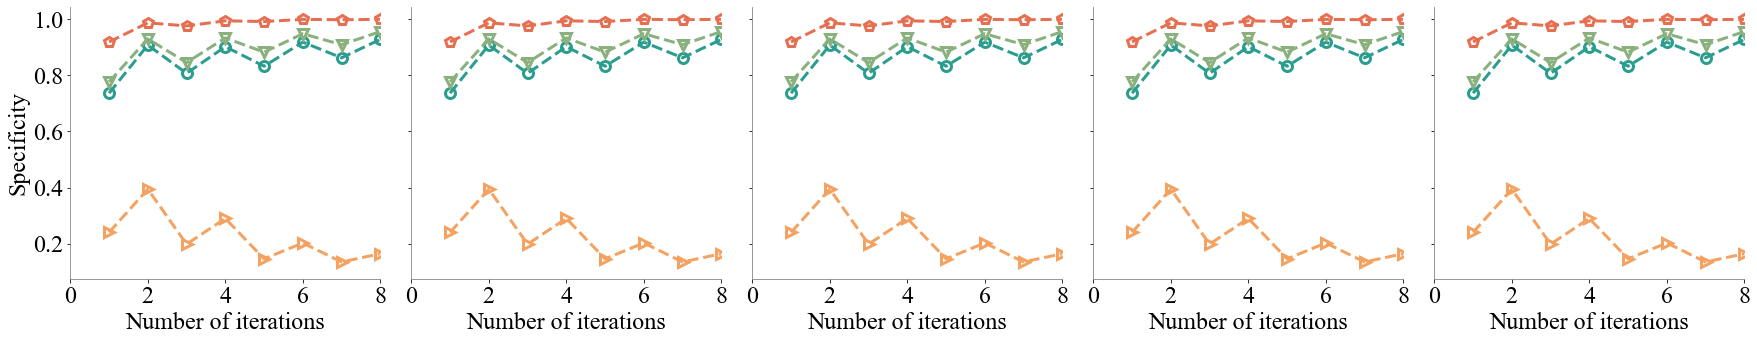

In [70]:
metrics = ['Recall', 'Specificity']
f1, axs1 = plt.subplots(1, 5, figsize=(30, 5), sharey=True)
axs1 = axs1.ravel()
for i, sc in enumerate(['sc1', 'sc2', 'sc3', 'sc4', 'sc5']):
   # recall = np.loadtxt('../results/1000/' + sc +'/step2_recall.txt')
    precision = np.loadtxt('../results/1000/' + sc +'/step2_precision.txt')
    
    #metrics = ['Recall', 'Specificity']
   # f1, axs1 = plt.subplots(1, 2, figsize=(16, 5))
   # axs1 = axs1.ravel()
    
    #for i, res in enumerate([recall,]):
    for index, label in enumerate(selected_label):
        axs1[i].plot([(i_iter+1) for i_iter in range(len(seeds))] , recall[idx_list[index]], lw=3,
                      marker = markers[index], markersize = 10, markeredgewidth=3,
                     linestyle='--', color = colrs[index],markerfacecolor="None",
                 label=label)

    axs1[i].set_xlabel('Number of iterations')
    axs1[i].set_ylabel('Specificity')
   # axs1[i].set_title('%s' %('Scenario ' + str(i+1)))
    axs1[i].set_xlim([0, 8])


    #axs1[i].title('Receiver operating characteristic for multi-class data')
   # axs1[i].legend(loc="best")

    if i > 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])

  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')

    
    for spine in ['left']: 
        axs1[i].spines[spine].set_edgecolor('gray')
   
            
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
        
    for spine in ['bottom']: 
            axs1[i].spines[spine].set_edgecolor('gray')
   
    #axs1[i].title('Receiver operating characteristic for multi-class data')

    #axs1[i].legend(loc="lower right")
  #  if i==0:
   #     axs1[i].legend(loc=(0.1, 1.2),ncol=4)
plt.subplots_adjust(wspace=0.1,hspace=0.05)
plt.savefig('../paper_codes/step2_specificity.jpg', dpi= 400, bbox_inches = "tight")

plt.show()


## Step1

In [807]:
fn = np.loadtxt('../results/1000/step1_fn.txt')
tn = np.loadtxt('../results/1000/step1_tn.txt')

In [808]:
fn

array([[57.6,  0. ,  0. ,  0. ,  0. ,  0. ],
       [66. , 27. , 20. , 16.6, 13.4, 11.2],
       [87.2, 66.8, 56. , 48. , 40. , 33.8]])

In [809]:
tn

array([[9265.8, 7406.4, 6516. , 5702.8, 4941.4, 4273.8],
       [8032. , 4383.8, 3553.6, 2942.2, 2464.8, 2065.4],
       [9053.2, 6630.6, 5718.4, 4963.6, 4277.8, 3656.8]])

## OpenSNP data

In [869]:
iters = 5
batch_size = [100, 200, 300]
p_thre = [0.15, 0.2, 0.25, 0.3]
seeds = [0, 100, 210, 970, 3506, 23525, 32451, 2466, 1242]

In [825]:
all_recall = np.zeros((1,12))
all_pre = np.zeros((1,12))

recall_list = np.argmax(recall, axis=1)
pre_list = np.argmax(precision, axis=1)

recall = np.loadtxt('../results/opensnp/' +'overall_recall.txt')
precision = np.loadtxt('../results/opensnp' +'/overall_precision.txt')

for i in range(12):
    
    all_recall[0,i] = recall[i,recall_list[i] ]
    all_pre[0, i] = precision[i, pre_list[i]]

    
gwar_recall = np.loadtxt('../results/opensnp/gwar/overall_recall.txt')
gwar_precesion =  np.loadtxt('../results/opensnp/gwar/overall_precision.txt')

#all_recall = all_recall.transpose()
#all_pre = all_pre.transpose()

In [ ]:
### step1 

In [870]:
new_labels = []
for idx, (batch, p) in enumerate(list(itertools.product(batch_size, p_thre))):
    new_labels.append(r'K = ' + str(batch) + r' & t = ' + str(p))
new_labels

['K = 100 & t = 0.15',
 'K = 100 & t = 0.2',
 'K = 100 & t = 0.25',
 'K = 100 & t = 0.3',
 'K = 200 & t = 0.15',
 'K = 200 & t = 0.2',
 'K = 200 & t = 0.25',
 'K = 200 & t = 0.3',
 'K = 300 & t = 0.15',
 'K = 300 & t = 0.2',
 'K = 300 & t = 0.25',
 'K = 300 & t = 0.3']

In [843]:
recall_list

array([1, 1, 7, 7, 7, 7, 7, 5, 7, 7, 1, 1])

In [844]:
pre_list

array([1, 7, 7, 7, 7, 7, 7, 5, 7, 7, 6, 1])

In [841]:
all_recall

array([[0.73971166, 0.79685452, 0.86841415, 0.91192661, 0.98138925,
        0.9921363 , 0.99475754, 0.99606815, 0.99842726, 0.99868938,
        0.99895151, 0.99973788]])

In [842]:
all_pre

array([[0.99195707, 0.99378057, 0.99596649, 0.9971205 , 0.99943888,
        0.99975106, 0.99982399, 0.99985586, 0.99995027, 0.99995607,
        0.99996384, 0.99998923]])

In [846]:
gwar_recall

array([0.74311927, 0.71690695, 0.77457405, 0.69724771, 0.73001311,
       0.73237221])

In [847]:
gwar_precesion

array([0.99293745, 0.99222098, 0.99378904, 0.99169125, 0.99256801,
       0.99264134])

In [845]:
# step2

In [ ]:
g

In [848]:
all_recall = np.zeros((1,12))
all_pre = np.zeros((1,12))

recall_list = np.argmax(recall, axis=1)
pre_list = np.argmax(precision, axis=1)

recall = np.loadtxt('../results/opensnp/' +'step2_recall.txt')
precision = np.loadtxt('../results/opensnp' +'/step2_precision.txt')

for i in range(12):
    
    all_recall[0,i] = recall[i,recall_list[i] ]
    all_pre[0, i] = precision[i, pre_list[i]]

#all_recall = all_recall.transpose()
#all_pre = all_pre.transpose()

In [849]:
recall_list

array([1, 1, 7, 7, 7, 7, 7, 5, 7, 7, 1, 1])

In [850]:
pre_list

array([1, 7, 7, 7, 7, 7, 7, 5, 7, 7, 6, 1])

In [851]:
all_recall

array([[0.74067416, 0.79771219, 0.8691124 , 0.9121705 , 0.98267439,
        0.99317584, 0.99553943, 0.99632821, 0.99973788, 0.99973788,
        0.99973719, 1.        ]])

In [852]:
all_pre

array([[0.96634337, 0.98307509, 0.99031537, 0.993626  , 0.99791592,
        0.99928377, 0.99956977, 0.99963721, 0.99995808, 0.99996449,
        0.99997129, 1.        ]])

In [853]:
## step1 

In [854]:
fn = np.loadtxt('../results/opensnp/step1_fn.txt')
tn = np.loadtxt('../results/opensnp/step1_tn.txt')

In [855]:
fn

array([1. , 0.8, 0.6, 0.2])

In [856]:
tn

array([18849. , 16621.6, 14619.2, 12837.2])

In [859]:
12837.2/28796

0.44579802750382

In [506]:
recall = np.loadtxt('../results/1000/' + 'sc1' +'/overall_recall.txt')

In [513]:
recall[idx_list

array([[0.7956044 , 0.91648352, 0.84175824, 0.90549451],
       [0.85274725, 0.94505495, 0.89450549, 0.94065934],
       [0.95604396, 0.9956044 , 0.98241758, 0.99340659],
       [0.96263736, 1.        , 0.99120879, 0.9978022 ]])

In [382]:
labels = []
for idx, (batch, p) in enumerate(list(itertools.product(batch_size, p_thre))):
    labels.append('K= ' + str(batch) + ' t= ' + str(p))

In [411]:
[labels[i] for i in [5, 11, 17, 23, 29, 35]]

['K= 100 t= 0.3',
 'K= 300 t= 0.3',
 'K= 500 t= 0.3',
 'K= 700 t= 0.3',
 'K= 900 t= 0.3',
 'K= 1100 t= 0.3']

In [406]:
labels

['K= 100 t= 0.005',
 'K= 100 t= 0.1',
 'K= 100 t= 0.15',
 'K= 100 t= 0.2',
 'K= 100 t= 0.25',
 'K= 100 t= 0.3',
 'K= 300 t= 0.005',
 'K= 300 t= 0.1',
 'K= 300 t= 0.15',
 'K= 300 t= 0.2',
 'K= 300 t= 0.25',
 'K= 300 t= 0.3',
 'K= 500 t= 0.005',
 'K= 500 t= 0.1',
 'K= 500 t= 0.15',
 'K= 500 t= 0.2',
 'K= 500 t= 0.25',
 'K= 500 t= 0.3',
 'K= 700 t= 0.005',
 'K= 700 t= 0.1',
 'K= 700 t= 0.15',
 'K= 700 t= 0.2',
 'K= 700 t= 0.25',
 'K= 700 t= 0.3',
 'K= 900 t= 0.005',
 'K= 900 t= 0.1',
 'K= 900 t= 0.15',
 'K= 900 t= 0.2',
 'K= 900 t= 0.25',
 'K= 900 t= 0.3',
 'K= 1100 t= 0.005',
 'K= 1100 t= 0.1',
 'K= 1100 t= 0.15',
 'K= 1100 t= 0.2',
 'K= 1100 t= 0.25',
 'K= 1100 t= 0.3']

In [689]:
recall = np.loadtxt('../results/1000/sc1/overall_recall.txt')
precision = np.loadtxt('../results/1000/sc1/overall_precision.txt')

In [690]:
gwar_recall = np.loadtxt('../results/1000/gwar/overall_recall.txt')
gwar_precesion = np.loadtxt('../results/1000/gwar/overall_precision.txt')

In [385]:
results

array([[0.0021978 , 0.00879121, 0.0021978 , 0.0021978 , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.21098901, 0.36043956, 0.0967033 , 0.15604396, 0.05494505,
        0.08791209, 0.03076923, 0.04835165, 0.01098901],
       [0.29010989, 0.47912088, 0.18901099, 0.28131868, 0.12967033,
        0.18461538, 0.09230769, 0.14065934, 0.05934066],
       [0.35384615, 0.57802198, 0.27692308, 0.41098901, 0.21098901,
        0.30549451, 0.17582418, 0.26153846, 0.14945055],
       [0.41978022, 0.65274725, 0.36263736, 0.51648352, 0.31868132,
        0.44395604, 0.27912088, 0.4       , 0.25274725],
       [0.47912088, 0.71868132, 0.43516484, 0.61538462, 0.41978022,
        0.56043956, 0.38241758, 0.5032967 , 0.37142857],
       [0.01978022, 0.03516484, 0.00659341, 0.01098901, 0.0043956 ,
        0.0043956 , 0.0021978 , 0.0021978 , 0.        ],
       [0.44175824, 0.71868132, 0.47032967, 0.63516484, 0.41978022,
        0.54285714, 0.38901099, 0.5032967 , 0.37582418],


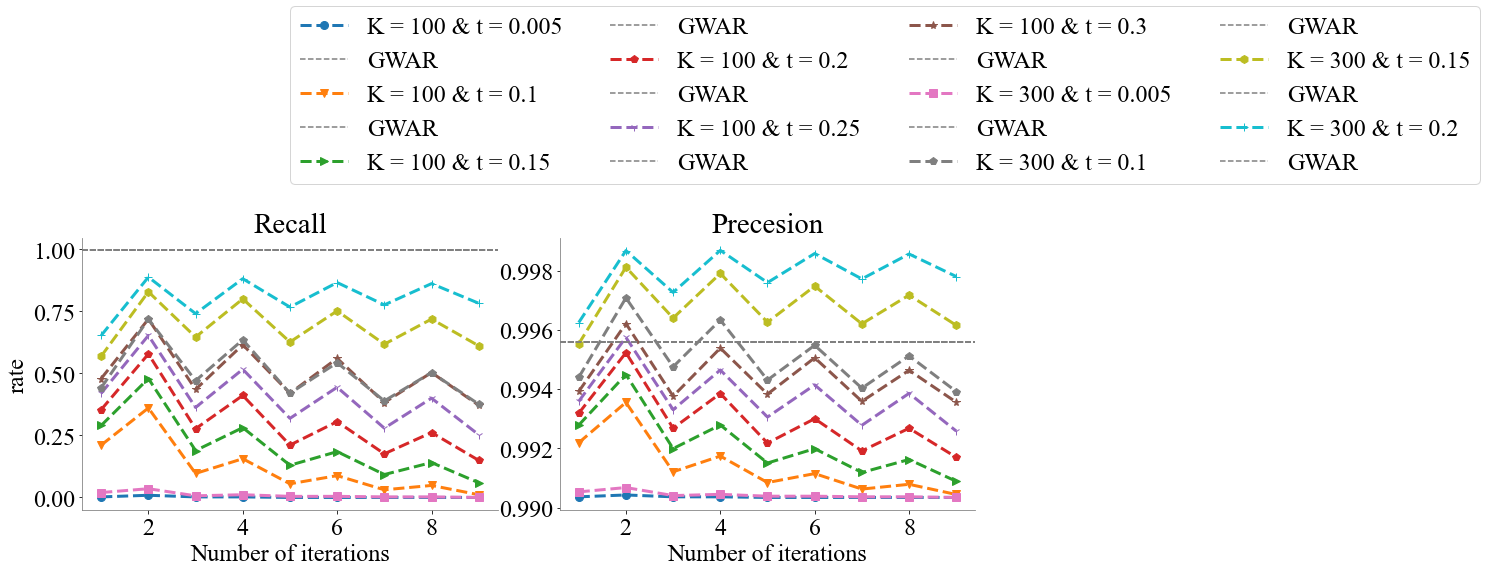

In [692]:
f1, axs1 = plt.subplots(1, 2, figsize=(16, 5))
axs1 = axs1.ravel()

metrics = ['Recall', 'Precesion','significant']



for i, res in enumerate([recall, precision]):
    for index, label in enumerate(labels[:10]):
        axs1[i].plot([(i_iter+1) for i_iter in range(len(seeds))] , res[index], lw=3,
                     marker = markers[index], markersize = 8, linestyle='--',
                 label=label)
        axs1[i].axhline(y=gwar_recall[0,-1], color='gray', linestyle='--', label = 'GWAR')

    axs1[i].set_xlabel('Number of iterations')
    axs1[i].set_ylabel('rate')
    axs1[i].set_title('%s' %(metrics[i]))


    #axs1[i].title('Receiver operating characteristic for multi-class data')
   # axs1[i].legend(loc="best")
    
    if i > 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i].spines[spine].set_edgecolor('gray')

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
    if i==0:
        axs1[i].legend(loc=(0.5, 1.2),ncol=4)
plt.subplots_adjust(wspace=0.15,hspace=0.05)
plt.show()

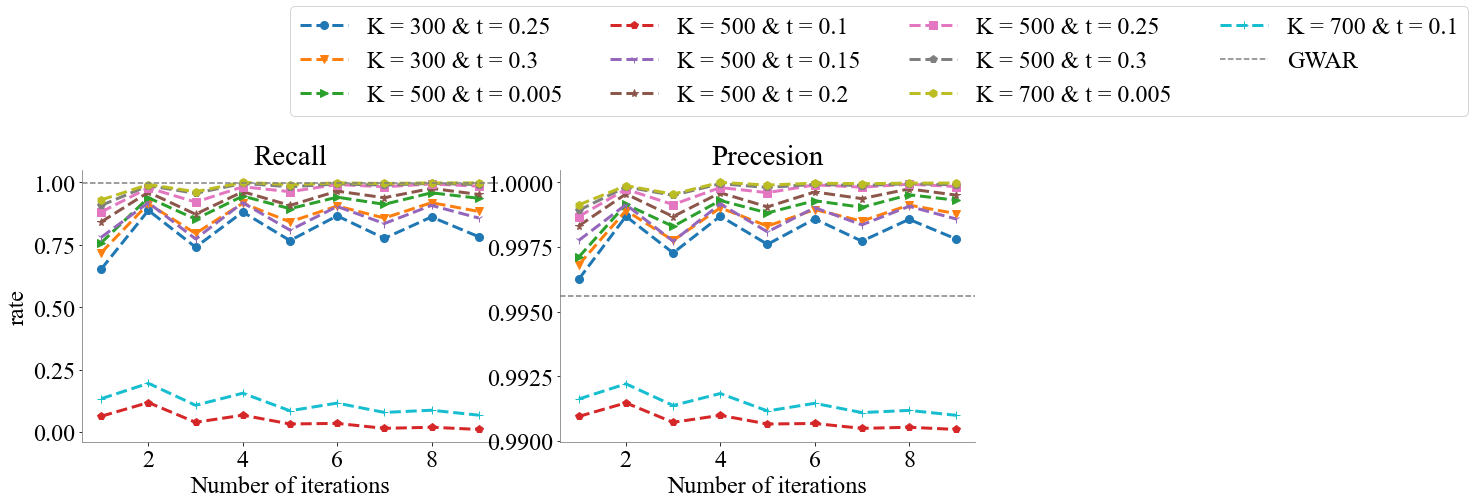

In [694]:
f1, axs1 = plt.subplots(1, 2, figsize=(16, 5))
axs1 = axs1.ravel()

metrics = ['Recall', 'Precesion','significant']



for i, res in enumerate([recall, precision]):
    for index, label in enumerate(labels[10:20]):
        axs1[i].plot([(i_iter+1) for i_iter in range(len(seeds))] , res[index+9], lw=3,
                     marker = markers[index], markersize = 8, linestyle='--',
                 label=label)
    axs1[i].axhline(y=gwar_recall[0,-1], color='gray', linestyle='--', label = 'GWAR')
    
    axs1[i].set_xlabel('Number of iterations')
    axs1[i].set_ylabel('rate')
    axs1[i].set_title('%s' %(metrics[i]))


    #axs1[i].title('Receiver operating characteristic for multi-class data')
   # axs1[i].legend(loc="best")
    
    if i > 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i].spines[spine].set_edgecolor('gray')

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
    if i==0:
        axs1[i].legend(loc=(0.5, 1.2),ncol=4)
plt.subplots_adjust(wspace=0.15,hspace=0.05)
plt.show()

In [702]:
labels[11]

'K = 300 & t = 0.3'

In [698]:
gwar_recall[0, -1]

0.9956043956043956

In [704]:
recall[10,:]

array([0.71868132, 0.91428571, 0.7956044 , 0.91648352, 0.84175824,
       0.90549451, 0.85714286, 0.91868132, 0.88351648])

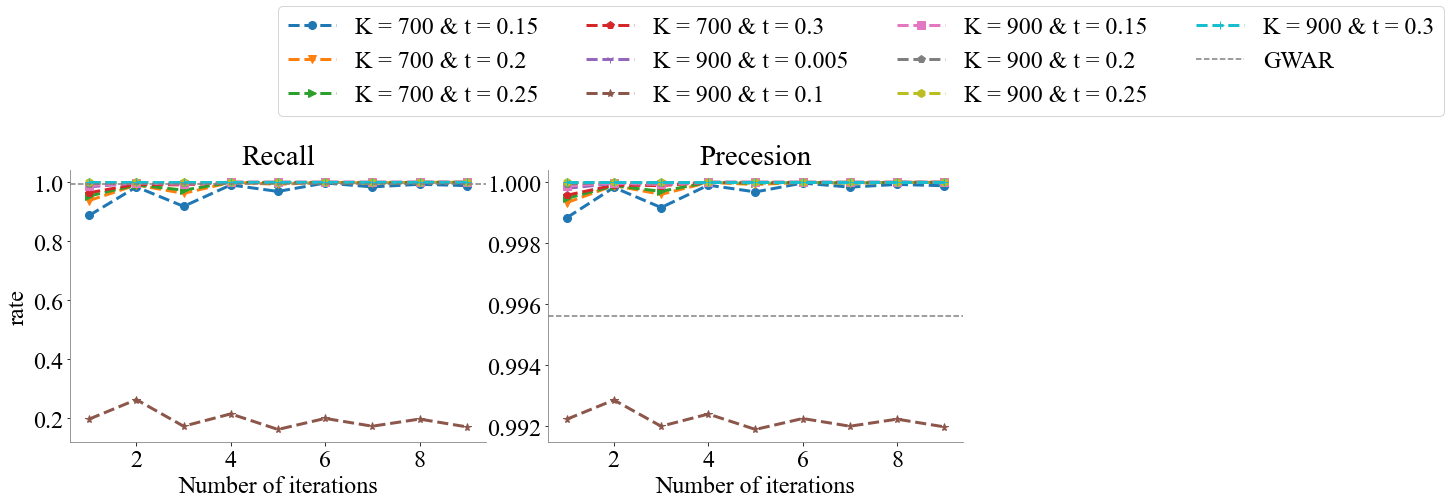

In [695]:
f1, axs1 = plt.subplots(1, 2, figsize=(16, 5))
axs1 = axs1.ravel()

metrics = ['Recall', 'Precesion','significant']



for i, res in enumerate([recall, precision]):
    for index, label in enumerate(labels[20:30]):
        axs1[i].plot([(i_iter+1) for i_iter in range(len(seeds))] , res[index+19], lw=3,
                     marker = markers[index], markersize = 8, linestyle='--',
                 label=label)
    axs1[i].axhline(y=gwar_recall[0,-1], color='gray', linestyle='--', label = 'GWAR')
    
    axs1[i].set_xlabel('Number of iterations')
    axs1[i].set_ylabel('rate')
    axs1[i].set_title('%s' %(metrics[i]))


    #axs1[i].title('Receiver operating characteristic for multi-class data')
   # axs1[i].legend(loc="best")
    
    if i > 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i].spines[spine].set_edgecolor('gray')

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
    if i==0:
        axs1[i].legend(loc=(0.5, 1.2),ncol=4)
plt.subplots_adjust(wspace=0.15,hspace=0.05)
plt.show()

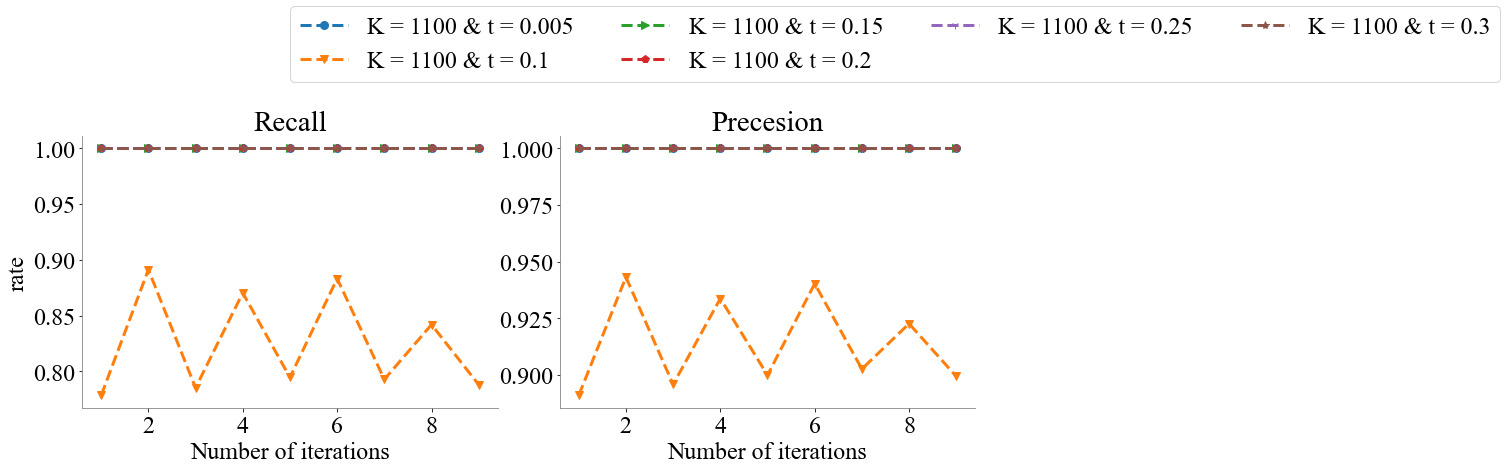

In [688]:
f1, axs1 = plt.subplots(1, 2, figsize=(16, 5))
axs1 = axs1.ravel()

metrics = ['Recall', 'Precesion','significant']


for i, res in enumerate([recall, precision]):
    for index, label in enumerate(labels[30:]):
        axs1[i].plot([(i_iter+1) for i_iter in range(len(seeds))] , res[index+29], lw=3,
                     marker = markers[index], markersize = 8, linestyle='--',
                 label=label)

    axs1[i].set_xlabel('Number of iterations')
    axs1[i].set_ylabel('rate')
    axs1[i].set_title('%s' %(metrics[i]))


    #axs1[i].title('Receiver operating characteristic for multi-class data')
   # axs1[i].legend(loc="best")
    
    if i > 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i].spines[spine].set_edgecolor('gray')

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
    if i==0:
        axs1[i].legend(loc=(0.5, 1.2),ncol=4)
plt.subplots_adjust(wspace=0.15,hspace=0.05)
plt.show()

In [432]:
labels

['K= 100 t= 0.005',
 'K= 100 t= 0.1',
 'K= 100 t= 0.15',
 'K= 100 t= 0.2',
 'K= 100 t= 0.25',
 'K= 100 t= 0.3',
 'K= 300 t= 0.005',
 'K= 300 t= 0.1',
 'K= 300 t= 0.15',
 'K= 300 t= 0.2',
 'K= 300 t= 0.25',
 'K= 300 t= 0.3',
 'K= 500 t= 0.005',
 'K= 500 t= 0.1',
 'K= 500 t= 0.15',
 'K= 500 t= 0.2',
 'K= 500 t= 0.25',
 'K= 500 t= 0.3',
 'K= 700 t= 0.005',
 'K= 700 t= 0.1',
 'K= 700 t= 0.15',
 'K= 700 t= 0.2',
 'K= 700 t= 0.25',
 'K= 700 t= 0.3',
 'K= 900 t= 0.005',
 'K= 900 t= 0.1',
 'K= 900 t= 0.15',
 'K= 900 t= 0.2',
 'K= 900 t= 0.25',
 'K= 900 t= 0.3',
 'K= 1100 t= 0.005',
 'K= 1100 t= 0.1',
 'K= 1100 t= 0.15',
 'K= 1100 t= 0.2',
 'K= 1100 t= 0.25',
 'K= 1100 t= 0.3']

In [484]:
recall = np.loadtxt('../results/1000/sc3/step2_recall.txt')
precision = np.loadtxt('../results/1000/sc3/step2_precision.txt')

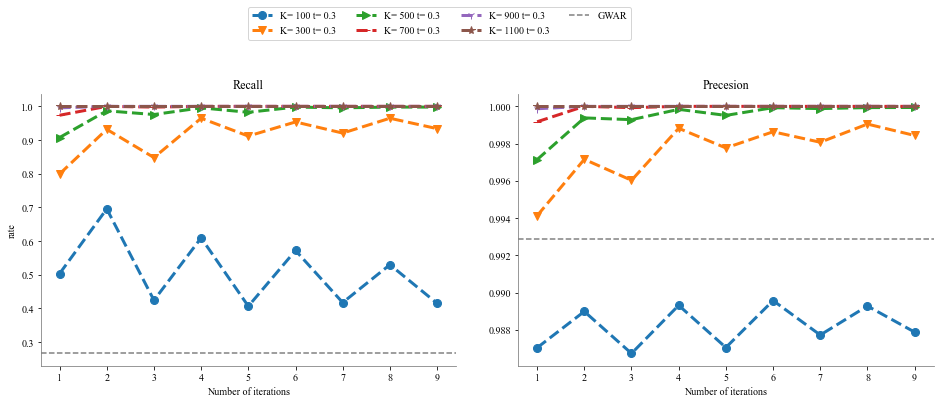

In [485]:
f1, axs1 = plt.subplots(1, 2, figsize=(16, 5))
axs1 = axs1.ravel()

metrics = ['Recall', 'Precesion','significant']


#idx_list = [5, 11, 17, 23, 29, 35]
idx_list = [0, 6, 12, 18, 24, 30]
labels_3 = [labels[i+5] for i in idx_list]

for i, res in enumerate([recall, precision]):
    if i==0:
        for index, label in enumerate(labels_3):
            axs1[i].plot([(i_iter+1) for i_iter in range(len(seeds))] , res[idx_list[index]+5], lw=3,
                         marker = markers[index], markersize = 8, linestyle='--',
                     label=label)
        axs1[i].axhline(y=gwar_recall[2,-1], color='gray', linestyle='--', label = 'GWAR')

        axs1[i].set_xlabel('Number of iterations')
        axs1[i].set_ylabel('rate')
        axs1[i].set_title('%s' %(metrics[i]))
    else:
        for index, label in enumerate(labels_3):
            axs1[i].plot([(i_iter+1) for i_iter in range(len(seeds))] , res[idx_list[index]+5], lw=3,
                         marker = markers[index], markersize = 8, linestyle='--',
                     label=label)
        axs1[i].axhline(y=gwar_precesion[2,-1], color='gray', linestyle='--', label = 'GWAR')

        axs1[i].set_xlabel('Number of iterations')
        axs1[i].set_ylabel('rate')
        axs1[i].set_title('%s' %(metrics[i]))

    #axs1[i].title('Receiver operating characteristic for multi-class data')
   # axs1[i].legend(loc="best")
    
    if i > 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i].spines[spine].set_edgecolor('gray')

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
    if i==0:
        axs1[i].legend(loc=(0.5, 1.2),ncol=4)
plt.subplots_adjust(wspace=0.15,hspace=0.05)
plt.show()

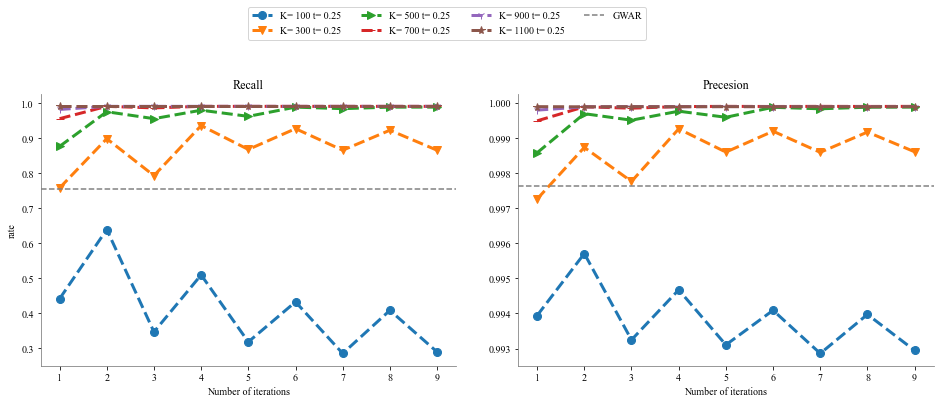

In [477]:
f1, axs1 = plt.subplots(1, 2, figsize=(16, 5))
axs1 = axs1.ravel()

metrics = ['Recall', 'Precesion','significant']


#idx_list = [5, 11, 17, 23, 29, 35]
idx_list = [0, 6, 12, 18, 24, 30]
labels_3 = [labels[i+4] for i in idx_list]

for i, res in enumerate([recall, precision]):
    if i==0:
        for index, label in enumerate(labels_3):
            axs1[i].plot([(i_iter+1) for i_iter in range(len(seeds))] , res[idx_list[index]+4], lw=3,
                         marker = markers[index], markersize = 8, linestyle='--',
                     label=label)
        axs1[i].axhline(y=gwar_recall[0,-1], color='gray', linestyle='--', label = 'GWAR')

        axs1[i].set_xlabel('Number of iterations')
        axs1[i].set_ylabel('rate')
        axs1[i].set_title('%s' %(metrics[i]))
    else:
        for index, label in enumerate(labels_3):
            axs1[i].plot([(i_iter+1) for i_iter in range(len(seeds))] , res[idx_list[index]+4], lw=3,
                         marker = markers[index], markersize = 8, linestyle='--',
                     label=label)
        axs1[i].axhline(y=gwar_precesion[0,-1], color='gray', linestyle='--', label = 'GWAR')

        axs1[i].set_xlabel('Number of iterations')
        axs1[i].set_ylabel('rate')
        axs1[i].set_title('%s' %(metrics[i]))

    #axs1[i].title('Receiver operating characteristic for multi-class data')
   # axs1[i].legend(loc="best")
    
    if i > 0 :
        axs1[i].set_ylabel('')
  #      axs1[i].set_xticks([])
        
  #  if i == 1 or i == 3:
   #     axs1[i].set_ylabel('')
    for spine in ['top', 'right']:  
        axs1[i].spines[spine].set_visible(False)
    for spine in ['left', 'bottom']: 
        axs1[i].spines[spine].set_edgecolor('gray')

    #axs1[i].title('Receiver operating characteristic for multi-class data')
    
    #axs1[i].legend(loc="lower right")
    if i==0:
        axs1[i].legend(loc=(0.5, 1.2),ncol=4)
plt.subplots_adjust(wspace=0.15,hspace=0.05)
plt.show()

In [415]:
gwar_recall = np.loadtxt('../results/1000/gwar/overall_recall.txt')
gwar_precesion = np.loadtxt('../results/1000/gwar/overall_precision.txt')

In [418]:
gwar_recall[0,-1]

0.756043956043956

In [478]:
fn = np.loadtxt('../results/1000/step1_fn.txt')
tn = np.loadtxt('../results/1000/step1_tn.txt')

In [479]:
fn

array([[57.6,  0. ,  0. ,  0. ,  0. ,  0. ],
       [57.6,  0. ,  0. ,  0. ,  0. ,  0. ],
       [73.4,  7.2,  2.2,  1.4,  0.8,  0.4]])

In [480]:
tn

array([[9265.8, 7406.4, 6516. , 5702.8, 4941.4, 4273.8],
       [9265.8, 7406.4, 6516. , 5702.8, 4941.4, 4273.8],
       [9265.4, 7582. , 6717. , 5934.4, 5188. , 4493.2]])

In [483]:
4493.2/9423

0.47683328027167565

In [956]:
data = pd.read_csv('../results/1000/sc2/dataset.csv', index_col='IID')

In [958]:
seeds = [0, 100, 210, 970, 3506, 23525, 32451, 2466, 1242]

used_sample_all = []
for n in [300, 500]:
    data_A, data_B = partition('human1000', data, '2', seeds[0])
    selected_uni = []
    for idn in range(len(seed)):
        df_uni = data_A.sample(n, random_state = seeds[idn])
        selected_uni.append(list(df_uni.index))
    
    used_sample = []
    for idn in range(len(seed)):
        used_sample.append(len(list(set().union(*[selected_uni[i] for i in range(idn+1)]))))
    
    used_sample_all.append(used_sample)

In [959]:
used_sample_all

[[300, 521, 685, 812, 913, 993, 1051, 1093, 1113],
 [500, 785, 956, 1063, 1118, 1154, 1175, 1182, 1193]]

In [960]:
selected_ratio = np.array(used_sample_all)/1200

In [961]:
selected_ratio

array([[0.25      , 0.43416667, 0.57083333, 0.67666667, 0.76083333,
        0.8275    , 0.87583333, 0.91083333, 0.9275    ],
       [0.41666667, 0.65416667, 0.79666667, 0.88583333, 0.93166667,
        0.96166667, 0.97916667, 0.985     , 0.99416667]])

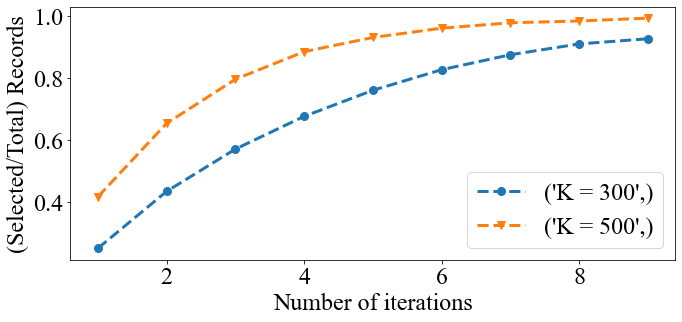

In [962]:
methods = ['k=100', 'k=200','k=300', 'k=400']
markers = ['o', 'v', '>', '_', '1', '*', 's', 'p', 'h', '+']


K_list = [300, 500]
#for num in [100, 200, 300, 400]:
 #   print(num)
        
f1, axs1 = plt.subplots(1,1, figsize=(10, 5))
#axs1 = axs1.ravel()

labels = ['K = 300', 'K = 500']

#for i, acc_res in enumerate([auc_]):
for index, (label) in enumerate(zip(labels)):
    axs1.plot([(i_iter+1) for i_iter in range(len(nss))] , selected_ratio[index], lw=3,
                 marker = markers[index], markersize = 8, linestyle='--',
             label=label)

axs1.set_xlabel('Number of iterations')
axs1.set_ylabel('(Selected/Total) Records')

#axs1.set_xlim([1,9])
#axs1.set_ylim([0.5,0.95])
    
#axs1.set_title('%s' %(relationships[i]))


#axs1[i].title('Receiver operating characteristic for multi-class data')
axs1.legend(loc="best")
plt.tight_layout()

In [612]:
4274/9423

0.45357104955958827

In [107]:
step1_time = np.load('../results/1000/sc1/step1_time.pkl', allow_pickle=True)

In [109]:
step2_time = np.load('../results/1000/sc1/step2_time.pkl', allow_pickle=True)

In [108]:
step1_time

[22.511185884475708,
 23.53749394416809,
 21.913054943084717,
 21.428730964660645,
 21.25071096420288]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8]

In [112]:
step2_time

[1.1015098094940186,
 1.0658068656921387,
 0.9876391887664795,
 1.0091311931610107,
 1.0915849208831787,
 1.120959997177124,
 26.301427364349365,
 25.08444905281067,
 26.27489686012268,
 27.538903951644897,
 28.55100107192993,
 29.81785297393799,
 36.08049774169922,
 36.339728116989136,
 37.38981914520264,
 39.33213686943054,
 41.392253160476685,
 43.7284038066864,
 44.532459020614624,
 45.022773027420044,
 44.236302852630615,
 45.35595703125,
 48.34490990638733,
 51.778990268707275,
 52.04811978340149,
 55.18471312522888,
 57.99989914894104,
 56.065305948257446,
 58.95397400856018,
 62.32053828239441,
 64.35587096214294,
 65.67591595649719,
 62.774041175842285,
 66.16437292098999,
 72.05151987075806,
 82.35164284706116,
 1.3627047538757324,
 1.2665750980377197,
 1.6257781982421875,
 1.311863899230957,
 1.4030489921569824,
 1.4683289527893066,
 24.06004023551941,
 27.19760298728943,
 27.665548086166382,
 29.487455129623413,
 30.310654878616333,
 31.88295578956604,
 37.04744815826416,
 